In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
%matplotlib inline
import pickle

#import keras
#from keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D, Flatten, Reshape, Dropout
#from keras.models import Sequential

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import tensorflow_io as tfio

from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)
else:
    print('no gpu')


In [3]:
features = pd.read_csv('data/features.csv', index_col=0, header=[0, 1, 2])
fma_single = pickle.load(open("saved/fma_single.p", "rb"))

In [4]:
fma_multi=pickle.load(open("saved/fma_multi.p","rb"))

In [5]:
fma_multi

,split,subset,filepath,genres_all,genre_top
track_id,,,,,
2,training,small,data/fma_large/000/000002.mp3,[21],Hip-Hop
3,training,medium,data/fma_large/000/000003.mp3,[21],Hip-Hop
5,training,small,data/fma_large/000/000005.mp3,[21],Hip-Hop
10,training,small,data/fma_large/000/000010.mp3,[10],Pop
20,training,large,data/fma_large/000/000020.mp3,"[17, 10, 76, 103]",NaN
...,...,...,...,...,...
155316,training,large,data/fma_large/155/155316.mp3,"[25, 12]",Rock
155317,training,large,data/fma_large/155/155317.mp3,"[25, 12]",Rock
155318,training,large,data/fma_large/155/155318.mp3,"[25, 12]",Rock


For the baseline model we are going to use the 'small' set of 8000 tracks in 8 classes, and train the model on the mfccs of the tracks which we extracted earlier.

In [6]:
#load mfccs
mfcc_df=pickle.load(open("saved/mfcc_small.p","rb"))

In [7]:
mfcc_df.shape

(7997, 23232)

In [8]:
mfcc_df.head()

,0,1,2,3,4,5,6,7,8,9,...,23222,23223,23224,23225,23226,23227,23228,23229,23230,23231
2,-299.542053,-202.513412,-159.976059,-115.456413,-80.415161,-67.523239,-57.689404,-65.464790,-84.703659,-96.179939,...,-5.861199,-4.460218,-6.887738,-7.665272,6.717929,12.769140,11.439809,9.167293,7.916427,5.665779
5,-324.059723,-227.421249,-186.883606,-158.489868,-94.902466,-95.517578,-106.146324,-70.498611,-45.091522,-41.156029,...,-6.403229,-4.675876,5.932048,19.163589,24.138350,12.146925,1.931949,-0.370714,1.137535,-0.625799
10,-71.376122,-32.296730,-29.356266,-38.037708,-44.881695,-45.910717,-31.081173,8.275231,28.077381,6.006516,...,9.814901,0.409050,-6.546686,-4.728213,-2.329597,4.121199,8.337200,8.429386,10.133602,11.033691
140,-561.324280,-523.545837,-449.814423,-342.445557,-306.727356,-308.809631,-307.733276,-317.345245,-362.774811,-419.306946,...,1.818927,3.912658,4.593844,2.139801,-4.394735,-5.267244,-6.697974,-5.783470,-5.886441,-3.706590
141,-464.980743,-371.434326,-330.917175,-342.813904,-362.013550,-368.364441,-361.755188,-358.438049,-365.668640,-375.685730,...,0.601643,-0.995060,0.146230,3.676285,-1.177926,-2.822582,4.884428,3.736303,2.701882,-2.805002


In [9]:
#use the 8000 track balanced subset for baseline modeling
subset = fma_single.index[fma_single['subset'] == 'small']
tracks_sub=fma_multi.loc[subset]
mfcc_sub=mfcc_df.loc[subset]


In [10]:
#fill nan
mfcc_sub.fillna(value=0,inplace=True)

In [11]:
print(len(mfcc_sub),len(tracks_sub))

7997 7997


In [12]:
#use the built in train/test/validation split in case we want to compare to other models over this dataset
train = tracks_sub.index[tracks_sub['split'] == 'training']
val = tracks_sub.index[tracks_sub['split'] == 'validation']
test = tracks_sub.index[tracks_sub['split'] == 'test']

In [13]:
print(len(train),len(val),len(test))

6397 800 800


In [14]:
#preprocessing single label

#enc=MultiLabelBinarizer()
enc=LabelEncoder()
labels=tracks_sub['genre_top']
#labels=y_df

# Split in training, validation and testing sets.

#single label
y_train = enc.fit_transform(labels[train])
y_val = enc.transform(labels[val])
y_test = enc.transform(labels[test])
#y_train = track_sub['label']

X_train = mfcc_sub.loc[train].values
X_val = mfcc_sub.loc[val].values
X_test = mfcc_sub.loc[test].values
    
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Standardize features
scaler =StandardScaler(copy=False)
X_train=scaler.fit_transform(X_train)
X_val=scaler.transform(X_val)
X_test=scaler.transform(X_test)

In [37]:
keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               11895296  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 520       
Total params: 12,068,296
Trainable params: 12,068,296
Non-trainable params: 0
_________________________________________________________________


In [38]:
with tf.device('/GPU:0'):
    history=model.fit(X_train,
              y_train,
              epochs=20,
              batch_size=128,
              validation_data=(X_val, y_val))

Epoch 1/20
50/50 [==============================] - 1s 23ms/step - loss: 2.3477 - accuracy: 0.2967 - val_loss: 2.0413 - val_accuracy: 0.3100
Epoch 2/20
50/50 [==============================] - 1s 15ms/step - loss: 1.5084 - accuracy: 0.4766 - val_loss: 1.9801 - val_accuracy: 0.3400
Epoch 3/20
50/50 [==============================] - 1s 14ms/step - loss: 1.1477 - accuracy: 0.6161 - val_loss: 2.0968 - val_accuracy: 0.3212
Epoch 4/20
50/50 [==============================] - 1s 15ms/step - loss: 0.7941 - accuracy: 0.7521 - val_loss: 2.1827 - val_accuracy: 0.3363
Epoch 5/20
50/50 [==============================] - 1s 11ms/step - loss: 0.4984 - accuracy: 0.8504 - val_loss: 2.5340 - val_accuracy: 0.3175
Epoch 6/20
50/50 [==============================] - 1s 13ms/step - loss: 0.3043 - accuracy: 0.9170 - val_loss: 2.7801 - val_accuracy: 0.3175
Epoch 7/20
50/50 [==============================] - 1s 15ms/step - loss: 0.2418 - accuracy: 0.9331 - val_loss: 3.1737 - val_accuracy: 0.3450
Epoch 8/20
50

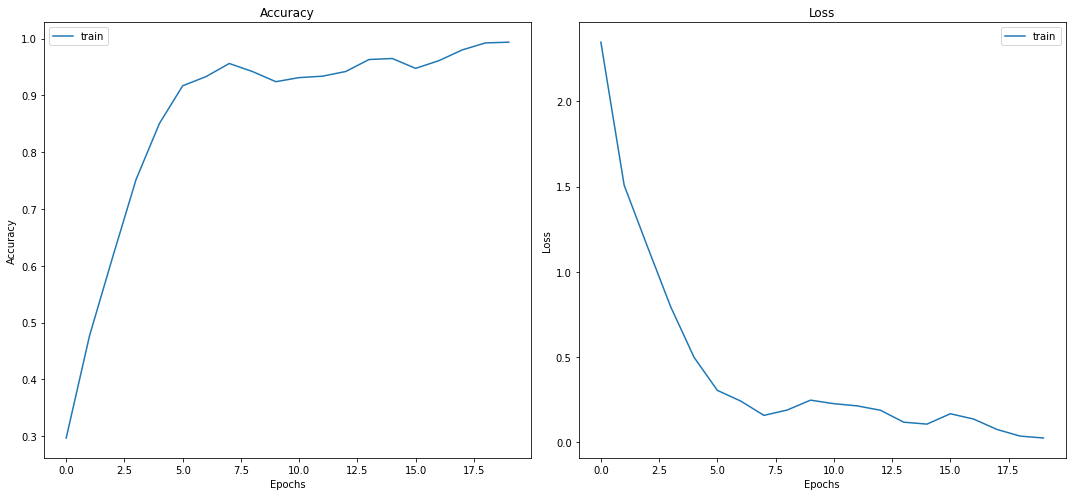

In [39]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
#plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
X_train.shape

(6397, 23232)

In [22]:
keras.backend.clear_session()

model = models.Sequential()

model.add(layers.Reshape((88,88,3),input_shape=(X_train.shape[1],)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (2,2), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(.2))
model.add(layers.Conv2D(128, (2,2), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Dropout(.2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
#model.add(tf.keras.backend.squeeze())
model.add(layers.Dense(8, activation='softmax'))

loss=tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='adam',
              loss=loss,
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 88, 88, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 86, 86, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 41, 41, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 128)       65664     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0

In [25]:
with tf.device('/GPU:0'):
    history=model.fit(X_train,
              y_train,
              epochs=40,
              batch_size=64,
              validation_data=(X_val, y_val))

Epoch 1/40
100/100 [==============================] - 3s 30ms/step - loss: 0.8329 - accuracy: 0.7041 - val_loss: 1.9079 - val_accuracy: 0.4200
Epoch 2/40
100/100 [==============================] - 3s 30ms/step - loss: 0.7879 - accuracy: 0.7178 - val_loss: 2.0365 - val_accuracy: 0.3925
Epoch 3/40
100/100 [==============================] - 3s 30ms/step - loss: 0.7362 - accuracy: 0.7375 - val_loss: 2.1331 - val_accuracy: 0.3638
Epoch 4/40
100/100 [==============================] - 3s 30ms/step - loss: 0.6777 - accuracy: 0.7647 - val_loss: 2.0981 - val_accuracy: 0.4025
Epoch 5/40
100/100 [==============================] - 3s 30ms/step - loss: 0.6440 - accuracy: 0.7747 - val_loss: 2.2773 - val_accuracy: 0.3812
Epoch 6/40
100/100 [==============================] - 3s 30ms/step - loss: 0.6083 - accuracy: 0.7783 - val_loss: 2.2362 - val_accuracy: 0.3750
Epoch 7/40
100/100 [==============================] - 3s 29ms/step - loss: 0.5594 - accuracy: 0.7976 - val_loss: 2.4631 - val_accuracy: 0.3837

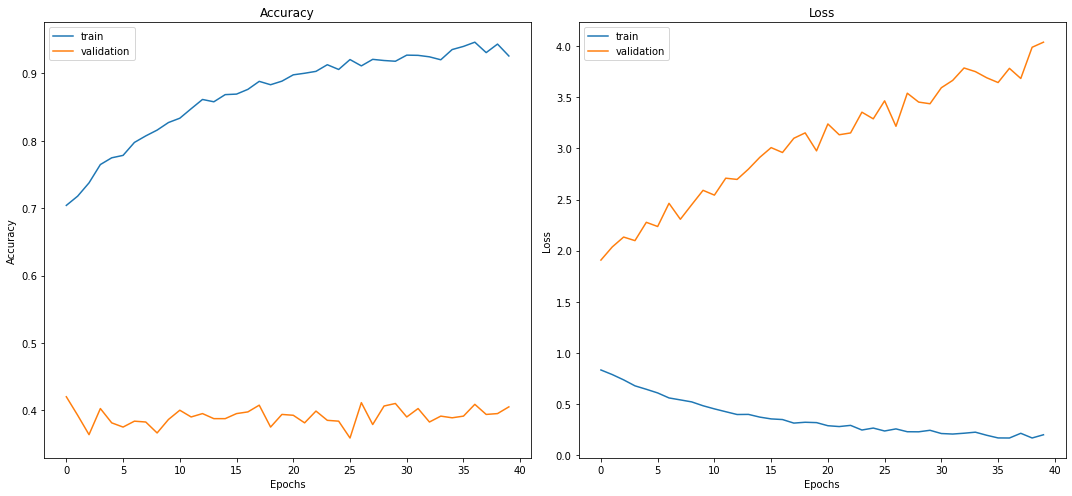

In [26]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
results = model.evaluate(X_test,y_test, return_dict=True)

25/25 [==============================] - 0s 7ms/step - loss: 4.6643 - accuracy: 0.3400


In [29]:
#make clear this is test set
y_pred=np.argmax(model.predict(X_test), axis=1)
print('Classification Report (test set)')
print(classification_report(y_test,y_pred))

Classification Report (test set)
              precision    recall  f1-score   support

           0       0.31      0.45      0.37       100
           1       0.25      0.25      0.25       100
           2       0.21      0.23      0.22       100
           3       0.52      0.54      0.53       100
           4       0.32      0.25      0.28       100
           5       0.35      0.38      0.36       100
           6       0.30      0.19      0.23       100
           7       0.48      0.43      0.46       100

    accuracy                           0.34       800
   macro avg       0.34      0.34      0.34       800
weighted avg       0.34      0.34      0.34       800



Over the set of:  
* 8 classes
* 1000 samples each class

A baseline model of a fully connected neural net achieves better accuracy over the test set than a Logistic Regression.

| Model | Accuracy(all classes) | Train Time |
| --- | --- | --- |
| Logistic Regression | .22 | 2m 36s |
| Neural Net | .30 | 8.34s |


I will extend this model using more complicated neural net architectures as follows:
* Convolutiona Neural Net (CNN)
* Long Short Term Memory (LSTM)
* Combination architecture with both CNN and LSTM layers